# Clustering Methods from scratch
During this experiment, we will implement clustering methods from scratch using Pytorch.<br>
The data used for training the unsupervised models was generated to show the difference between K-means and Gaussian Mixture.

In [218]:
import os
import math

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [219]:
def data_generator(cluster_nums, cluster_means, cluster_var,
                   background_range, background_noise_nums):
    """Generates data using a mutivariate normal distribution

    Args:
        cluster_nums: Number of clusters.
        cluster_means: A list or numpy array describing the mean of each clusters.
        cluster_var: A list or numpy array describing the variance of each clusters.
        background_range: A tuple containing the range of the background noise.
        background_noise_nums: Number of background noise points.

    Returns:
        A 2d numpy array.
    """
    data = []
    for num, mu, var in zip(cluster_nums, cluster_means, cluster_var):
        data += [np.random.multivariate_normal(mu, np.diag(var), num)]
    data = np.vstack(data)
    noise = np.random.uniform(background_range[0], background_range[1], size=(background_noise_nums, data.shape[-1]))
    data = np.append(data, noise, axis=0)
    return data

In [220]:
X = data_generator(cluster_nums=[400,600,800],
                   cluster_means=[[0.5, 0.5],
                                  [6, 1.5],
                                  [1, 7]],
                   cluster_var=[[1, 3],
                                [2, 2],
                                [6, 2]],
                   background_range=[[-10, -15],
                                     [15, 20]],
                   background_noise_nums=30)

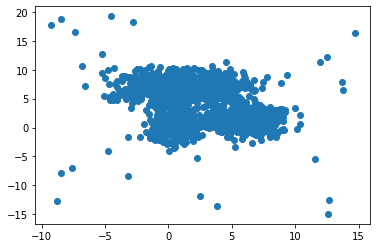

In [221]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Our goal is to separate the data into groups where the samples in each group are similar.

### Standardize the data
The K-means method is a distance based approach for clustering.<br>
It is mandatory to standardize the data to prevent the features with higher values to contribute more than the others.<br>
In a real world application, we would have standardize the data performing the following lines.
But as we generated the data, the is no need to do it.

In [ ]:
X_s = StandardScaler().fit_transform(X)
X_s = torch.from_numpy(X_s).float()

### K-Means Clustering
K-means algorithm is an iterative approach that tries to partition a dataset into $K$ predefined clusters where each data point belongs to only one cluster.
            
This algorithm works that way:
- specify number of clusters $K$
- randomly initialize one centroid in space for each cluster
- for each point, compute the euclidean distance between the point and each centroid and assign the point to the closest centroid
- change the centroid value based on the points present in each cluster and repeat the previous step until the centroid does not change anymore

The approach, K-means follows to solve this problem is called Expectation-Maximization. The E-step assign each point to a cluster, and the M-step refines the value of centroid based on the points inside each cluster.

More formally, the objective function to minimize is as follows:<br>
$$
    \large J = \sum_{i=1}^{m} \sum_{k=1}^{K} \mathbb{I}(z_i = k)||x_i - \mu_k||_2^2
$$<br>
where $z_i$ is the cluster assigned to $x_i$ and $\mu_k$ is the mean of the cluster $k$.

The E-step is defined as:<br>
$$
    \large z_i^{*} = \text{argmin}_{k} ||x_i - \mu_k||_2^2
$$<br>

And the M-step is defined as:<br>
$$
    \large \mu_k = \frac{1}{\sum_{i=1}^m \mathbb{I}(z_i = k)} \sum_{i=1}^m  x_i\mathbb{I}(z_i = k)
$$<br>

In practice, we should run multiple K-means with different initialization of the centroids and keep the parameters that min
Since K-means is a distance based algorithm, is it mandatory to standardize the data. 

In [222]:
class KMeansClustering():
    """K-Means class implemented in Pytorch


    Attributes:
        n_clusters: A integer describing in how many clusters to separate the data.
        centroids: A torch tensor containing in each column the mean of the n'th
            cluster.
        
    Usage:
        kms = KMeansClustering(n_clusters=3)
        pred = kms.fit_transform(X)
    """
    
    
    def __init__(self, n_clusters=5):
        """Inits KmeansClustering class setting the number of clusters"""
        self.n_clusters = n_clusters
        self.centroids = None
        
    
    def fit_transform(self, X, n_iter=20):
        """Trains the KMeans and clusterize the input data
        
        Args:
            X: A numpy array constituting the data to separate.
            n_iters: A integer describing the number of iterations of
                expectation maximization to perform.
        
        """
        size = X.shape[0]
        # Find min and max values to generate a random centroid in this range
        xmax = X.max(dim=0)[0].unsqueeze(1)
        xmin = X.min(dim=0)[0].unsqueeze(1)
        
        dists = torch.zeros((size, self.n_clusters))
        best_loss = 1e10
        pred = None
        
        for _ in range(n_iter):
            centroids = (xmin - xmax) * torch.rand((X.shape[1], self.n_clusters)) + xmax
            old_loss = -1
            while 1:
                for i in range(self.n_clusters):  # E-step: assign each point to a cluster
                    ctr = centroids[:, i].unsqueeze(1)
                    dists[:, i] = (X - ctr.T).pow(2).sum(dim=1).sqrt()
                dists_min, labels = dists.min(dim=1)
                
                for i in range(self.n_clusters):  # M-step: re-compute the centroids
                    idx = torch.where(labels == i)[0]
                    if len(idx) == 0:
                        continue
                    centroids[:, i] = X[idx].mean(dim=0)
                    
                new_loss = dists_min.sum()  # Loss: sum distance between points and centroid
                if old_loss == new_loss:
                    break
                old_loss = new_loss
            if new_loss < best_loss:
                best_loss = new_loss
                pred = labels
        return pred

In [223]:
X = torch.from_numpy(data).float()

In [224]:
kms = KMeansClustering(n_clusters=3)
pred = kms.fit_transform(X)

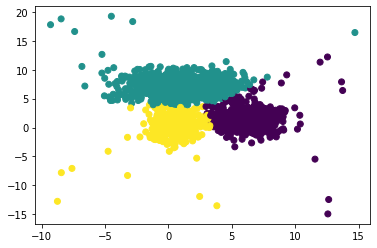

In [225]:
plt.scatter(X[:, 0], X[:, 1], c=pred)

The result is pretty satisfying. Each cluster is well separated from each other.<br>
Let's see if we can get the same result using a Gaussian Mixture model.

### Gaussian Mixture Model
In order to understand how we train a Gaussian Mixture model, we must explain the expectation-maximization algorithm (EM) first.<br>
The EM algorithm is a general technique for finding maximum likelihood solutions for probabilistic models having latent variables. EM is an iterative algorithm that starts from an initial estimate of the parameters of a probabilistic model $\boldsymbol{\theta}$ and then proceeds to iteratively update $\boldsymbol{\theta}$ until convergence. This algorithm consists to iteratively apply an expectation step and a maximization step.
            
Let's consider the EM algorithm for a multivariate Gaussian Mixture model with $K$ mixture components, observed variables $\boldsymbol{X}$ and latent variables $\boldsymbol{Z}$ such as:<br>

$$
\large
\begin{aligned}
    P(\boldsymbol{x}_i | \boldsymbol{\theta}) &= \sum_{k=1}^{K} \pi_k P(\boldsymbol{x}_i | \boldsymbol{z}_i, \boldsymbol{\theta}_k)\\
    &= \sum_{k=1}^{K} P(\boldsymbol{z}_i = k) \mathcal{N}(\boldsymbol{x}_i; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
\end{aligned}
$$<br>
where each component of the mixture model is the normal distribution.
Let's see why the MLE of a gaussian mixture model is hard to compute. The likelihood of a gaussian mixture distribution is:<br>
$$
\large
    L(\boldsymbol{\theta} | \boldsymbol{X}) = \prod_{i=1}^N\sum_{k=1}^{K} \pi_k \mathcal{N}(\boldsymbol{x}_i; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$<br>

This the log-likelihood is as follows:<br>
$$
\large
    \mathcal{L}(\boldsymbol{\theta} | \boldsymbol{X}) = \sum_{i=1}^N \log\left(\sum_{k=1}^{K} \pi_k \mathcal{N}(\boldsymbol{x}_i; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)\right)
$$<br>

Because of the sum inside the $\log$, we cannot estimate $\boldsymbol{\mu}_k$ and $\boldsymbol{\sigma^2}$ without knowing $\boldsymbol{Z}$. That is why we would use EM in this kind of situation.

The EM algorithm has two steps, the expectation step known as E-step, assigns to each data point the probability that they belong to each
components of the mixture model. Whereas the maximization step, known as M-step, re-evaluate the parameters of each mixture component based on the estimated values generated in the E-step.

More formally, during the E-step, we calculate the likelihood of each data point using the estimated parameters:<br>
$$
\large
    f(\boldsymbol{x_i}|\mu_k, \boldsymbol{\Sigma}_k) = \frac{1}{\sqrt{(2\pi)^m|\boldsymbol{\Sigma}_k|}} \exp\left(-\frac{(\boldsymbol{x}_i - \boldsymbol{\mu}_k)^\top \boldsymbol{\Sigma}_k^{-1}(\boldsymbol{x}_i - \boldsymbol{\mu}_k)}{2}\right)
$$<br>
where $m$ is the number of features in the input data.

Then we compute the probability that $\boldsymbol{x}_i$ came from the $k^{th}$ gaussian distribution:<br>
$$
\Large
    p_{ik} = \frac{\pi_k f(\boldsymbol{x_i}|\mu_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^{K} \pi_j f(\boldsymbol{x_i}|\mu_j, \boldsymbol{\Sigma}_j)}
$$<br>

For the M-step, we update the parameters of the mixture as follows:<br>
$$
\Large
\begin{aligned}
    \pi_k &= \frac{1}{N}\sum_{i=1}^{N} p_{ik}\\
    \boldsymbol{\mu}_k &= \frac{1}{\sum_{i=1}^{N} p_{ik}} \sum_{i=1}^{N} p_{ik} \boldsymbol{x_i}\\
    \boldsymbol{\Sigma}_k &= \frac{1}{\sum_{i=1}^{N} p_{ik}} \sum_{i=1}^{N} p_{ik} (\boldsymbol{x}_i - \boldsymbol{\mu}_k) (\boldsymbol{x}_i - \boldsymbol{\mu}_k)^\top
\end{aligned}
$$

In [226]:
class GaussianMixture():
    """Gaussian Mixture model class separating data in clusters
    
    The KMeans class in used to initialize the probabilities of
    each sample to belong to a given gaussian component.
    
    Attributes:
        n_components: An integer for the number of gaussian distribution in the mixture.
        n_iter: An inter for the number of iterations to perform e-step and m-step.
        priors: A torch tensor containing the probabilities of each class.
        mu: A torch tensor holding the mean of each gaussian component.
        sigma: A torch tensor holding the covariance of each gaussian component.
        likelihoods: A torch tensor holding the likelihoods of each data from each gaussian.
        probs: A torch tensor holding the probabilities for each data to belong to each
            gaussian.
    
    Usage:
        gmm = GaussianMixture(n_components=3, n_iter=3)
        pred = gmm.fit_predict(X)
    """
    def __init__(self, n_components, n_iter):
        """Inits the GaussianMixture class by setting n_components and n_iter"""
        self.n_components = n_components
        self.n_iter = n_iter
        
    def gaussian_likelihood(self, X, n):
        """Returns the gaussian likelihood of X from the nth gaussian"""
        two_pi = torch.tensor(2 * math.pi, dtype=torch.float64)
        fact = 1 / torch.sqrt(torch.pow(two_pi, X.shape[0]) * torch.det(self.sigma[n]))
        
        X_minus_mu = X - self.mu[n].T
        sigma_inv = torch.inverse(self.sigma[n])
        return fact * torch.exp(-0.5 * X_minus_mu.mm(sigma_inv).mm(X_minus_mu.T))
        
    def e_step(self, X):
        """Assigns to each data the probability to belong to each gaussian"""
        for j in range(self.n_components):
            for i in range(self.n_samples):
                self.likelihoods[i, j] = self.gaussian_likelihood(X[i], j)
                
        # Tensor to hold the probabilities that each data belongs to each gaussian
        
        prob_num = self.priors.T * self.likelihoods
        prob_den = prob_num.sum(dim=1).unsqueeze(1)
        self.probs = prob_num / prob_den
        
    def m_step(self, X):
        """Re-computes the parameters of each gaussian component"""
        for j in range(self.n_components):
            probs_j = self.probs[:, j]  # All probabilities from the j'th guassian
            probs_j_sum = probs_j.sum()
            self.priors[j] = probs_j.sum() / self.n_samples
            
            probs_j_uns = probs_j.unsqueeze(1)
            
            # Recomputes the means of each gaussian based on the probabilities of
            # each data.
            
            self.mu[j] = (probs_j_uns * X).sum(dim=0).unsqueeze(1)
            self.mu[j] /= probs_j_sum
            
            # Recomputes the covariance matrix of each data
            
            X_minus_mu = X - self.mu[j].T
            self.sigma[j].fill_(0.)
            for i in range(self.n_samples):
                row = X_minus_mu[i, :].unsqueeze(1)
                self.sigma[j] += probs_j[i] * row.mm(row.T)
            self.sigma[j] /= probs_j_sum
            
    def fit_predict(self, X):
        """Trains the models and returns clusters"""
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        
        self.sigma = torch.zeros((self.n_components, self.n_features, self.n_features), dtype=torch.float64)
        self.mu = torch.zeros((self.n_components, self.n_features, 1), dtype=torch.float64)
        self.priors = torch.zeros((self.n_components, 1), dtype=torch.float64).fill_(1 / self.n_components)
        
        # Initialize the probabilities of each samples to belong
        # to each gaussian by a KMeans
        
        kms = KMeansClustering(n_clusters=self.n_components)
        pred = kms.fit_transform(X).unsqueeze(1)
        self.probs = torch.zeros(self.n_samples, self.n_components)
        self.probs.scatter_(1, pred, 1)
        
        # Set the covariance parameter of each components to the
        # covariance of the data
        
        X_m = X - X.mean()
        X_cov = X_m.T.mm(X_m)
        for j in range(self.n_components):
            self.sigma[j] = X_cov.clone()
            # Select a random sample as the mean of each gaussian
            self.mu[j] = X[torch.randint(0, self.n_samples, (1,))].T
        
        self.likelihoods = torch.zeros((self.n_samples, self.n_components), dtype=torch.float64)
        
        self.m_step(X)  # Start with m_step to compute params of gaussians based on KMeans probabilities
        for _ in range(self.n_iter):
            self.e_step(X)
            self.m_step(X)
            
        return self.probs.argmax(dim=1)

In [229]:
gmm = GaussianMixture(n_components=3, n_iter=3)
pred_gmm = gmm.fit_predict(X)

Text(0.5, 1.0, 'GMM clusters')

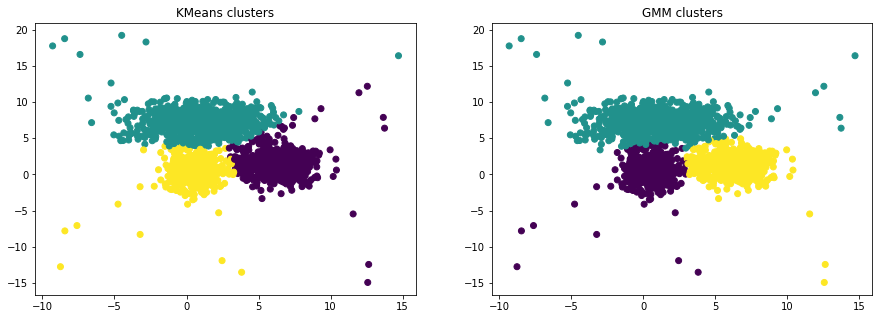

In [230]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(data[:, 0], data[:, 1], c=pred)
ax2.scatter(data[:, 0], data[:, 1], c=pred_gmm)
ax1.set_title('KMeans clusters')
ax2.set_title('GMM clusters')

### Conclusion
The KMeans algorithm can only describe spherical clusters while GMM can express elliptic clusters.<br>
In this experiment, GMM clearly found the gaussian distributions that we generated.<br>
Whereas KMeans did a great job to separate the data but still lacks expressivity for clustering gaussian distributions.

KMeans is significantly faster and simpler than other EM algorithm, but for data that has different sized and shaped clusters, GMM does a better job. However, GMM is known to be unstable. Indeed, the clusters can be a little bit different each time.<br>

If we had to choose one assertion to take out of this experiments, it would be that clustering methods are very powerful techniques suited for finding latent or missing variables.